In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import librosa as lb
import os

In [3]:
patient_data=pd.read_csv('/content/drive/MyDrive/CNN_Detection/respiratory_sound_dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
path='/content/drive/MyDrive/CNN_Detection/respiratory_sound_dataset/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
path
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['151_2p4_Lr_mc_AKGC417L',
 '151_2p4_Ar_mc_AKGC417L',
 '151_2p4_Al_mc_AKGC417L',
 '151_2p4_Ll_mc_AKGC417L',
 '151_2p3_Tc_mc_AKGC417L']

In [5]:
def getFilenameInfo(file):
    return file.split('_')

In [6]:
def extractId(filename):
    return filename.split('_')[0]

In [7]:
path='/content/drive/MyDrive/processed_audio_files'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,130,130_3p4_Al_mc_AKGC417L_2.wav
1,130,130_3p4_Al_mc_AKGC417L_3.wav
2,130,130_3p4_Al_mc_AKGC417L_4.wav
3,130,130_3p4_Al_mc_AKGC417L_5.wav
4,130,130_3p4_Al_mc_AKGC417L_6.wav


In [8]:
files_df.pid=files_df.pid.astype('int64')
data=pd.merge(files_df,patient_data,on='pid')
data.head()
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [9]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [10]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.840159
Healthy           0.042712
Pneumonia         0.037649
URTI              0.035007
Bronchiolitis     0.022897
Bronchiectasis    0.015412
LRTI              0.005284
Asthma            0.000881
Name: disease, dtype: float64

In [11]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.840159
Healthy           0.042933
Pneumonia         0.037649
URTI              0.035007
Bronchiolitis     0.022457
Bronchiectasis    0.015192
LRTI              0.005284
Asthma            0.001321
Name: disease, dtype: float64

In [12]:
train=pd.read_csv('/content/drive/MyDrive/csv_data/train.csv')
val=pd.read_csv('/content/drive/MyDrive/csv_data/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,3457,184,184_1b1_Ar_sc_Meditron_4.wav,Healthy
1,4393,170,170_1b2_Al_mc_AKGC417L_1.wav,COPD
2,2561,207,207_2b2_Pl_mc_AKGC417L_2.wav,COPD
3,2178,203,203_1p2_Al_mc_AKGC417L_6.wav,COPD
4,4762,174,174_1p3_Ar_mc_AKGC417L_2.wav,COPD


In [13]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1509    COPD
1510    COPD
1511    COPD
1512    COPD
1513    COPD
Name: disease, Length: 1514, dtype: object

In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [15]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)
    rms=lb.feature.rms(y=soundArr)
    return mfcc,cstft,mSpec,rms

In [16]:
root='/content/drive/MyDrive/processed_audio_files/'
mfcc,cstft,mSpec,rms=[],[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c,d=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    rms.append(d)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)
rms_val=np.array(rms)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [17]:
root='/content/drive/MyDrive/processed_audio_files/'
mfcc,cstft,mSpec,rms=[],[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c,d=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    rms.append(d)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)
rms_train=np.array(rms)

In [18]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout,Reshape,Multiply
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
def squeeze_excite_block(inputs, ratio=16):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = tf.keras.layers.GlobalMaxPool2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

In [20]:
checkpoint=ModelCheckpoint(r'mfcc_eval',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0.001,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)
my_callbacks=[checkpoint,earlystop]

In [38]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [39]:
mfcc_model.summary()

Model: "mfccModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfccInput (InputLayer)         [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 20, 87, 32)   832         ['mfccInput[0][0]']              
                                                                                                  
 global_max_pooling2d_6 (Global  (None, 32)          0           ['conv2d_15[0][0]']              
 MaxPooling2D)                                                                                    
                                                                                          

In [40]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [41]:
croma_model.summary()

Model: "cromaModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cromaInput (InputLayer)        [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 12, 87, 32)   832         ['cromaInput[0][0]']             
                                                                                                  
 global_max_pooling2d_11 (Globa  (None, 32)          0           ['conv2d_19[0][0]']              
 lMaxPooling2D)                                                                                   
                                                                                         

In [42]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [43]:
rms_input=keras.layers.Input(shape=(1,259,1),name="rmsInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(rms_input)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.Conv2D(64,5,strides=(2,3),padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.Conv2D(96,5,strides=(2,3),padding='same')(x)
x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
rms_output=keras.layers.GlobalMaxPooling2D()(x)

rms_model=keras.Model(rms_input, rms_output, name="rmsModel")

In [44]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)

input_rms=keras.layers.Input(shape=(1,259,1),name="rms")
rms=rms_model(input_rms)


concat=keras.layers.concatenate([mfcc,croma,mSpec,rms])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(256,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(128,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec,input_rms], output, name="Net")

In [45]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [46]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [47]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train,"rms":rms_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val},yval),
    epochs=100,
    callbacks=my_callbacks
)

Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.8247
Epoch 1: val_loss did not improve from 0.15865
142/142 [==============================] - 91s 563ms/step - loss: 0.6776 - accuracy: 0.8247 - val_loss: 1.1087 - val_accuracy: 0.8402
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8448
Epoch 2: val_loss did not improve from 0.15865
142/142 [==============================] - 80s 562ms/step - loss: 0.4607 - accuracy: 0.8448 - val_loss: 0.4567 - val_accuracy: 0.8408
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8633
Epoch 3: val_loss did not improve from 0.15865
142/142 [==============================] - 78s 549ms/step - loss: 0.3718 - accuracy: 0.8633 - val_loss: 1.1791 - val_accuracy: 0.5839
Epoch 4/100
142/142 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8699
Epoch 4: val_loss did not improve from 0.15865
142/142 [=============

In [48]:
from sklearn.metrics import RocCurveDisplay

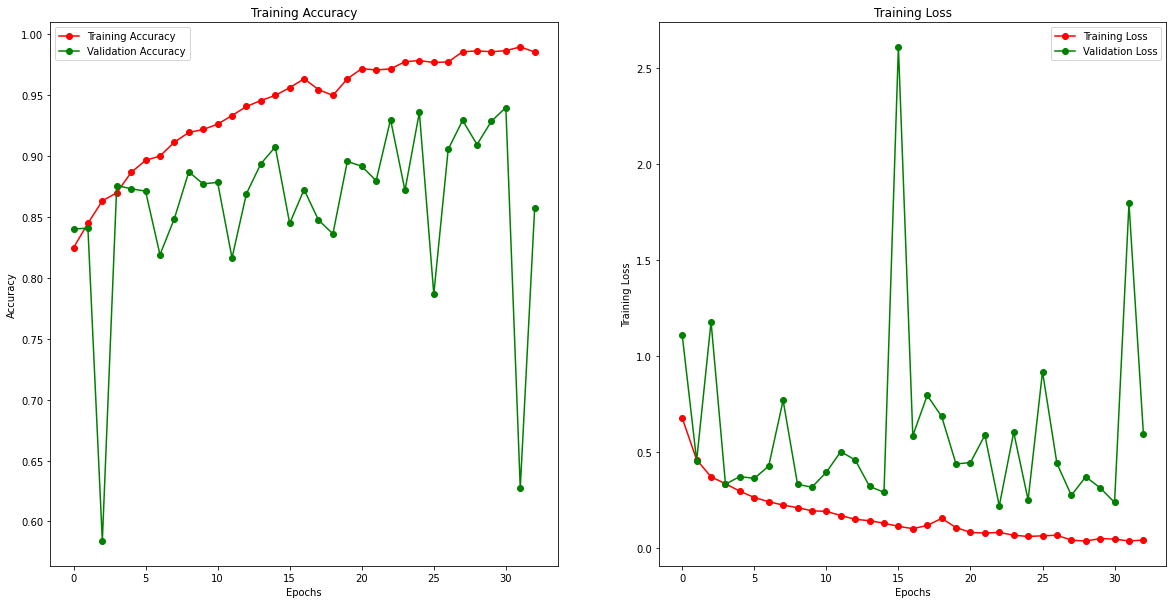

In [49]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [50]:
net.evaluate({"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train,"rms":rms_train},ytrain)
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val},yval)

48/48 [==============================] - 6s 118ms/step - loss: 0.2205 - accuracy: 0.9300


[0.22048115730285645, 0.9299867749214172]

48/48 [==============================] - 7s 119ms/step
0.9993386243386244
0.9953926457294491
0.9853338632750397
0.995507172929986
0.9825025216329565
0.9746015936254979
0.9906440775927464
0.9811320754716981


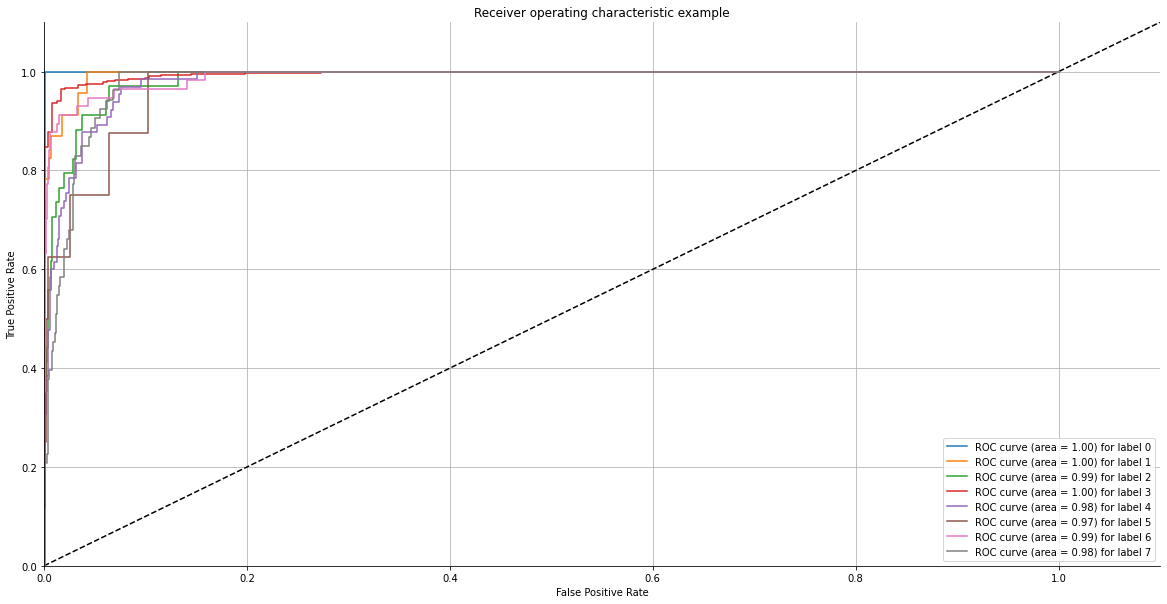

In [51]:
from sklearn.metrics import roc_curve,auc
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(roc_auc[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 5], [0, 5], 'k--')
    ax.set_xlim([0.0, 1.1])
    ax.set_ylim([0.0, 1.1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=10.0)
    sns.despine()
    plt.show()

plot_multiclass_roc(net, {"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val}, yval, n_classes=8, figsize=(20, 10))

In [52]:
from sklearn.metrics import confusion_matrix
y_pred = net.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val})

y_pred = np.argmax(y_pred,axis=1)
confusion = confusion_matrix(yval, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(yval, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(yval, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(yval, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(yval, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(yval, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(yval, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(yval, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(yval, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(yval, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(yval, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(yval, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']))

48/48 [==============================] - 6s 118ms/step
Confusion Matrix

[[   0    0    0    2    0    0    0    0]
 [   0   18    0    2    1    0    0    2]
 [   0    1   15    2   12    0    0    4]
 [   0    1    0 1254   13    0    4    0]
 [   0    0    2    3   57    0    0    3]
 [   0    0    0    0    5    0    0    3]
 [   0    0    0   14    2    0   41    0]
 [   0    0    2    0   26    1    1   23]]

Accuracy: 0.93

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.59
Macro Recall: 0.53
Macro F1-score: 0.54

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00         2
     Class 2       0.90      0.78      0.84        23
     Class 3       0.79      0.44      0.57        34
     Class 4       0.98      0.99      0.98      1272
     Class 5       0.49      0.88      0.63        65
     Class 6       

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr